In [17]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (accuracy_score, classification_report, 
                             ConfusionMatrixDisplay, confusion_matrix)
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

In [3]:
# Synthetic series with regimes & jumps
n=500
dates=pd.bdate_range('2021-01-01', periods=n)
mu = np.where(np.arange(n)<n//2, 0.0003, -0.0001)
sigma = np.where(np.arange(n)<n//2, 0.01, 0.015)
eps = np.random.normal(mu, sigma)
jumps = np.zeros(n); jump_days = np.random.choice(np.arange(20,n-20), size=5, replace=False)
jumps[jump_days] = np.random.normal(0,0.05,size=len(jump_days))
rets = eps + jumps
price = 100*np.exp(np.cumsum(rets))
df = pd.DataFrame({'price':price}, index=dates)
df['ret'] = df['price'].pct_change().fillna(0.0)
df['log_ret'] = np.log1p(df['ret'])
df.head()

,price,ret,log_ret
2021-01-01,101.735412,0.000000,0.000000
2021-01-04,101.292875,-0.004350,-0.004359
2021-01-05,101.356527,0.000628,0.000628
2021-01-06,101.800950,0.004385,0.004375
2021-01-07,101.031283,-0.007561,-0.007589


In [5]:
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
# df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,y_next_ret,y_up
2021-01-08,101.063685,0.000321,0.000321,-0.007561,-0.001379,0.000291,1
2021-01-11,101.093108,0.000291,0.000291,0.000321,-0.001315,-0.017099,0
2021-01-12,99.364481,-0.017099,-0.017247,0.000291,-0.000387,0.010532,1
2021-01-13,100.410953,0.010532,0.010477,-0.017099,-0.003933,0.006325,1
2021-01-14,101.046042,0.006325,0.006305,0.010532,-0.002703,-0.005937,0


In [36]:
df['lag_1'] = df['ret'].shift(1)
df['rolling_vol_20'] = df['ret'].rolling(20).std().shift(1)
df['y_up'] = (df['ret'].shift(-1) > 0).astype(int)
df_feat = df.dropna().copy()

features = ['lag_1', 'rolling_vol_20']
X = df_feat[features]
y = df_feat['y_up']

split_pct = 0.8
split_idx = int(len(X) * split_pct)

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")

Training set size: 383 samples
Test set size: 96 samples


In [38]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(random_state=42))])

In [40]:
# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Down (0)', 'Up (1)']))

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}\n")


Classification Report:
              precision    recall  f1-score   support

    Down (0)       0.55      0.81      0.66        53
      Up (1)       0.44      0.19      0.26        43

    accuracy                           0.53        96
   macro avg       0.50      0.50      0.46        96
weighted avg       0.50      0.53      0.48        96

Model Accuracy: 0.5312



Confusion Matrix:


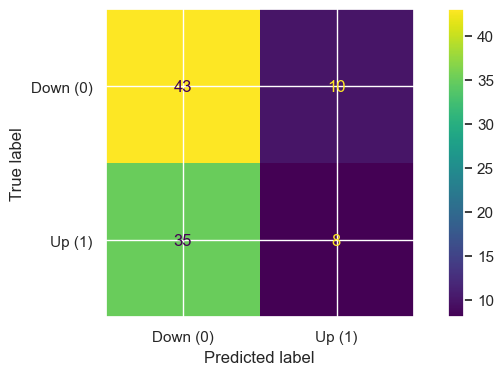

In [42]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot()
plt.show()

**Data Interpretation**

The model shows no real predictive power. Its 50% accuracy is equivalent to a random coin flip. The precision, recall, and F1-scores all hover around 0.50, confirming this lack of performance.

Moreover, the features used (lag_1, rolling_vol_20) were too simple to capture the complex and noisy dynamics of financial returns. This result is very typical and highlights the inherent difficulty of financial market prediction.